# Set Label

In [1]:
real = ['LJSpeech-1.1', 'data']
generated = ['generated_audio']

# List up Dataset

In [2]:
import os
os.getcwd()
os.chdir('/root/NetChallenge10')

PATH = os.path.join(os.getcwd(), 'dataset')


In [3]:
def search_wav(label, path):
    temp = []

    for file in os.listdir(path):
        file_path = os.path.join(path, file)

        if(os.path.isdir(file_path)):
            temp += search_wav(label, file_path)
        elif(os.path.splitext(file_path)[-1] == '.wav'):
            temp.append([label, file_path])
    
    return temp
        

In [4]:
# real_dataset_list
label = 'real'
real_dataset_list = []
for folder in real:
    real_dataset_list += search_wav(label, os.path.join(PATH, folder))
    print(folder, len(real_dataset_list))
# fake_dataset_list
label = 'fake'
fake_dataset_list = []
for folder in generated:
    fake_dataset_list += search_wav(label, os.path.join(PATH, folder))
    print(folder, len(fake_dataset_list))

LJSpeech-1.1 13100
data 24017
generated_audio 134266


# Analyze Dataset

In [69]:
print('length of real:', len(real_dataset_list))
print('length of fake:', len(fake_dataset_list))

length of real: 24018
length of fake: 134266


# Generate Balanced Dataset

In [70]:
import random
balanced_fake_data_list = random.sample(fake_dataset_list, len(real_dataset_list))
print(len(balanced_fake_data_list))
print(balanced_fake_data_list[:10])

24018
[['fake', '/root/NetChallenge10/dataset/generated_audio/ljspeech_melgan_large/LJ010-0256_gen.wav'], ['fake', '/root/NetChallenge10/dataset/generated_audio/common_voices_prompts_from_conformer_fastspeech2_pwg_ljspeech/gen_6358.wav'], ['fake', '/root/NetChallenge10/dataset/generated_audio/common_voices_prompts_from_conformer_fastspeech2_pwg_ljspeech/generated/gen_5099.wav'], ['fake', '/root/NetChallenge10/dataset/generated_audio/ljspeech_multi_band_melgan/LJ014-0243_gen.wav'], ['fake', '/root/NetChallenge10/dataset/generated_audio/ljspeech_waveglow/LJ039-0061.wav'], ['fake', '/root/NetChallenge10/dataset/generated_audio/ljspeech_waveglow/LJ050-0136.wav'], ['fake', '/root/NetChallenge10/dataset/generated_audio/ljspeech_melgan_large/LJ013-0136_gen.wav'], ['fake', '/root/NetChallenge10/dataset/generated_audio/ljspeech_full_band_melgan/LJ030-0122_gen.wav'], ['fake', '/root/NetChallenge10/dataset/generated_audio/common_voices_prompts_from_conformer_fastspeech2_pwg_ljspeech/generated/gen

# save as json

In [71]:
# save all
import json

PATH = "/root/NetChallenge10"
base_json = {"data":[]}

for label, path in real_dataset_list+fake_dataset_list:
    data = {
        "label" : label,
        "wav" : path
    }

    base_json['data'].append(data)

# save preprocessed data
os.makedirs(os.path.join(PATH, 'data'), exist_ok=True)
with open(os.path.join(PATH, 'data', 'total_data.json'),'w') as j:
    json.dump(base_json,j,ensure_ascii=False, indent=4)


In [72]:
# save all
import json

PATH = "/root/NetChallenge10"
base_json = {"data":[]}

for label, path in real_dataset_list+balanced_fake_data_list:
    data = {
        "label" : label,
        "wav" : path
    }

    base_json['data'].append(data)

# save preprocessed data
os.makedirs(os.path.join(PATH, 'data'), exist_ok=True)
with open(os.path.join(PATH, 'data', 'balanced_total_data.json'),'w') as j:
    json.dump(base_json,j,ensure_ascii=False, indent=4)


# Split train and test

In [75]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(base_json['data'], train_size=0.8, test_size=0.2, random_state=123, shuffle=True)
print(train_data[0])
print(test_data[0])
print(len(train_data), len(test_data))


{'label': 'fake', 'wav': '/root/NetChallenge10/dataset/generated_audio/ljspeech_melgan_large/LJ040-0089_gen.wav'}
{'label': 'real', 'wav': '/root/NetChallenge10/dataset/LJSpeech-1.1/LJSpeech-1.1/wavs/LJ002-0220.wav'}
38428 9608


In [76]:
train_path = os.path.join(PATH, 'data', 'train_preprocessed_data.json')
print("Train 데이터셋 저장")
train_json = {'data' : train_data}
with open(train_path,'w') as j:
    json.dump(train_json,j,ensure_ascii=False, indent=4)

test_path = os.path.join(PATH, 'data', 'test_preprocessed_data.json')
print("Test 데이터셋 저장")
test_json = {'data' : test_data}
with open(test_path,'w') as j:
    json.dump(test_json,j,ensure_ascii=False, indent=4)


Train 데이터셋 저장
Test 데이터셋 저장


# Kwav2Vec Encoder Test

In [2]:
import os
import torch
from torch import nn

import soundfile as sf
from transformers import Wav2Vec2Processor, Wav2Vec2Model

def encoding(raw_wavs,cuda, processor=None, encoder=None, return_hidden_state=False):
    assert bool(processor) == bool(encoder)

    # Audio reshape
    if len(raw_wavs.shape) > 1:
        raw_wavs = raw_wavs.reshape((1,-1)).squeeze()
    inputs = processor(raw_wavs,
                       sampling_rate=16000,
                       return_attention_mask=True,
                       return_tensors="pt")
    inputs = inputs.to(cuda)
    encoder = encoder.to(cuda)
    outputs = encoder(output_hidden_states=return_hidden_state, **inputs)
    torch.cuda.empty_cache()
    return inputs, outputs

class Kwav2vec():
    def __init__(self, config):
        self.args = config
        self.file_path = self.args.path
        self.max_len = self.args.max_length
        self.processor = Wav2Vec2Processor.from_pretrained("kresnik/wav2vec2-large-xlsr-korean")
        self.encoder = Wav2Vec2Model.from_pretrained("kresnik/wav2vec2-large-xlsr-korean")
        self.len_ = len(os.listdir(self.args.path))

    def readfile(self,path):
        wav, _ = sf.read(path)
        return wav

    def _encoding(self,raw_wav,output_hidden_state=False):
        encoded, extract_feature = encoding(raw_wavs=raw_wav,
                                   cuda=self.args.cuda,
                                   encoder=self.encoder,
                                   processor=self.processor,
                                   return_hidden_state=output_hidden_state)

        return encoded, extract_feature

    def encoding_one_data(self, data):
        self.encoder.to(self.args.cuda)
        
        with torch.no_grad():
            wav = self.readfile(data['wav'])
            encoded, processored = self._encoding(wav, output_hidden_state=False)
            pooled_hidden = processored.last_hidden_state

        return wav, processored, encoded, pooled_hidden
    
    def __call__(self,batch):

        hidden_batch = torch.Tensor().to(self.args.cuda)

        for data in batch:
            hidden = self.encoding_one_data(data)
            seq = hidden.size()[1]

            if seq > self.max_len:
                # truncation
                hidden = hidden[:,:self.max_len,:].to(self.args.cuda)
            elif seq < self.max_len:
                # padding
                pad = torch.Tensor([[[0]*1024]*(self.max_len-seq)]).to(self.args.cuda)
                hidden = torch.cat([hidden,pad], dim=1)

            hidden_batch = torch.cat([hidden_batch,hidden],dim=0)

        return hidden_batch

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pandas as pd
from config import *

audio_encoder = Kwav2vec(pd.Series(audio_config))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at kresnik/wav2vec2-large-xlsr-korean were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
from torch.utils.data.dataloader import DataLoader
from merdataset import *
dataset = MERGEDataset(data_option='train', path='./data/')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True,
                                    collate_fn=lambda x: (x, torch.FloatTensor([i['label'] for i in x])))

In [5]:
for batchid, data in enumerate(dataloader):
    print(batchid, data)
    break
print(data[0][0])

0 ([{'label': [0, 1], 'wav': '/root/NetChallenge10/dataset/generated_audio/ljspeech_parallel_wavegan/LJ048-0229_gen.wav'}], tensor([[0., 1.]]))
{'label': [0, 1], 'wav': '/root/NetChallenge10/dataset/generated_audio/ljspeech_parallel_wavegan/LJ048-0229_gen.wav'}


In [101]:
wav, processored, encoded, pooled_hidden = audio_encoder.encoding_one_data(data[0][0])
#wav, processored, encoded = audio_encoder.encoding_one_data(data[0][0])

# Draw outputs

In [64]:
!pip install librosa
!pip install matplotlib

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


[-1.92260742e-03 -9.46044922e-04  8.23974609e-04 ... -9.15527344e-05
 -9.15527344e-05  0.00000000e+00]


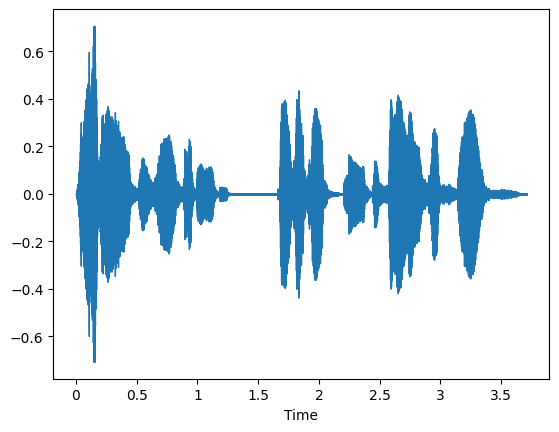

In [102]:
import librosa
print(wav)
librosa.display.waveshow(wav)

In [103]:
for k, v in encoded.items():
    print('k:', k, 'v:', v)

print(encoded['input_values'])

k: input_values v: tensor([[-2.6522e-02, -1.3089e-02,  1.1257e-02,  ..., -1.3361e-03,
         -1.3361e-03, -7.6826e-05]], device='cuda:0')
k: attention_mask v: tensor([[1, 1, 1,  ..., 1, 1, 1]], device='cuda:0', dtype=torch.int32)
tensor([[-2.6522e-02, -1.3089e-02,  1.1257e-02,  ..., -1.3361e-03,
         -1.3361e-03, -7.6826e-05]], device='cuda:0')


In [104]:
print(encoded['input_values'].shape)
print(len(wav))
print(encoded['input_values'].tolist()[0][0])
print(wav[0])
print(max(encoded['input_values'].tolist()[0]))
print(max(wav))

torch.Size([1, 81821])
81821
-0.026521902531385422
-0.001922607421875
9.725415229797363
0.707061767578125


In [105]:
wav_path = '/root/NetChallenge10/dataset/generated_audio/ljspeech_waveglow/LJ035-0189.wav'

data, sr = sf.read(wav_path)
print(sr)
print(data)
print(len(data))
print('time', len(data)//sr)

22050
[-3.35693359e-04 -3.96728516e-04 -9.15527344e-05 ... -3.96728516e-04
 -3.66210938e-04 -3.35693359e-04]
124928
time 5


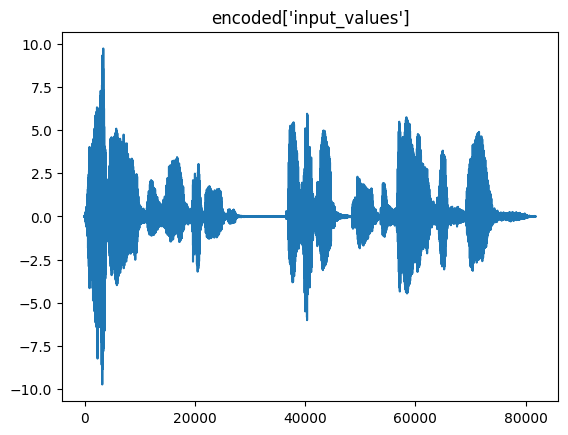

In [108]:
import matplotlib.pyplot as plt

plt.plot(encoded['input_values'].tolist()[0])
plt.title("encoded['input_values']")
plt.show()

Text(0.5, 1.0, 'pooled_hidden')

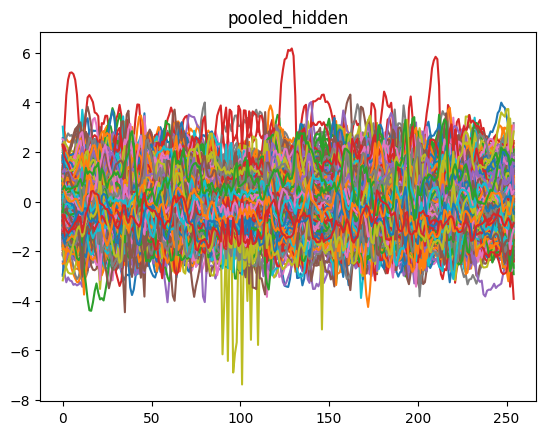

In [110]:
#pooled_hidden
plt.plot(pooled_hidden.tolist()[0])
plt.title('pooled_hidden')

# Model Architecture check

In [58]:
import argparse
import random
from tqdm import tqdm

import torch
import numpy as np
import pandas as pd
from torch.utils.data.dataloader import DataLoader

from models.kwav2vec_model import *
from merdataset import *
from config import *
from utils import *
import time
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "0"

audio_conf = pd.Series(audio_config)
classifier_conf = pd.Series(classifier_config)


#audio_conf['path'] = './TOTAL/Extracted_Dataset/'

# 데이터셋 불러오기


# 모델 생성
model = Kwav2vec_classfier(audio_conf, classifier_conf)
print(model)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at kresnik/wav2vec2-large-xlsr-korean were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Kwav2vec_classfier(
  (classifier): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=768, out_features=512, bias=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
  (projection): Conv1d(1024, 768, kernel_size=(1,), stride=(1,), bias=False)
  (avgpool): AdaptiveAvgPool1d(output_size=1)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [60]:
print(model.audio_encoder.encoder)

Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
      (1-4): 4 x Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=1024, bias=True)
    (dropout)

# Feature Extraction

In [18]:
import os
import torch
from torch import nn

import soundfile as sf
from tqdm import tqdm

from transformers import Wav2Vec2Processor, Wav2Vec2Model


class Kwav2vec():
    def __init__(self, config):
        self.args = config
        self.file_path = self.args.path
        self.max_len = self.args.max_length
        self.processor = Wav2Vec2Processor.from_pretrained("kresnik/wav2vec2-large-xlsr-korean")
        self.encoder = Wav2Vec2Model.from_pretrained("kresnik/wav2vec2-large-xlsr-korean")
        self.len_ = len(os.listdir(self.args.path))

    def encoding_one_data(self, data):
        os.makedirs(self.args.path + 'hidden_states', exist_ok=True)
        embed_path = self.args.path + 'hidden_states/'
        self.encoder.to(self.args.cuda)
        
        with torch.no_grad():
            wav = self.readfile(data['wav'])
            encoded = self._encoding(wav, output_hidden_state=False)
            pooled_hidden = encoded.last_hidden_state
            torch.save(pooled_hidden, embed_path + j[:-4] + '.pt')
            torch.cuda.empty_cache()
        return pooled_hidden

    def readfile(self,path):
        wav, _ = sf.read(path)
        return wav

    def encoding(self, raw_wavs,cuda, processor=None, encoder=None, return_hidden_state=False):
        assert bool(processor) == bool(encoder)

        # Audio reshape
        if len(raw_wavs.shape) > 1:
            raw_wavs = raw_wavs.reshape((1,-1)).squeeze()
        inputs = processor(raw_wavs,
                        sampling_rate=16000,
                        return_attention_mask=True,
                        return_tensors="pt")
        inputs = inputs.to(cuda)
        #encoder = encoder.to(cuda)
        #outputs = encoder(output_hidden_states=return_hidden_state, **inputs)
        #torch.cuda.empty_cache()
        return inputs

    def _encoding(self,raw_wav,output_hidden_state=False):
        extract_feature = self.encoding(raw_wavs=raw_wav,
                                   cuda=self.args.cuda,
                                   encoder=self.encoder,
                                   processor=self.processor,
                                   return_hidden_state=output_hidden_state)

        return extract_feature

    def __call__(self,batch):

        hidden_batch = torch.Tensor().to(self.args.cuda)

        for data in batch:
            hidden = self.encoding_one_data(data)
            seq = hidden.size()[1]

            if seq > self.max_len:
                # truncation
                hidden = hidden[:,:self.max_len,:].to(self.args.cuda)
            elif seq < self.max_len:
                # padding
                pad = torch.Tensor([[[0]*1024]*(self.max_len-seq)]).to(self.args.cuda)
                hidden = torch.cat([hidden,pad], dim=1)

            hidden_batch = torch.cat([hidden_batch,hidden],dim=0)

        return hidden_batch

In [19]:
import argparse
import random
from tqdm import tqdm

import torch
import numpy as np
import pandas as pd
from torch.utils.data.dataloader import DataLoader

from models.kwav2vec_model import *
from merdataset import *
from config import *
from utils import *
import time
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "0"

audio_conf = pd.Series(audio_config)
classifier_conf = pd.Series(classifier_config)
encoder = Kwav2vec(audio_conf)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at kresnik/wav2vec2-large-xlsr-korean were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
from torch.utils.data.dataloader import DataLoader
from merdataset import *
import os 
print(os.getcwd())
batch_size = 32
dataset = MERGEDataset(data_option='train', path='./data/')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True,
                                    collate_fn=lambda x: (x, torch.FloatTensor([i['label'] for i in x])))

path = '/root/NetChallenge10/dataset/hidden_state'
os.makedirs(path, exist_ok=True)

/root/NetChallenge10


In [40]:
import time

total_time = 0
total_datanum = 0
for batch_id, batch in enumerate(dataloader):
    for data in batch[0]:
        # 시간 측정
        start = time.time()

        # 음성파일 인코딩
        encoded = encoder.encoding_one_data(data)
        total_datanum += 1
        # 인코딩된 음성파일 저장
        torch.save(encoded,  os.path.join(path, 'Extracted_feature'+ '.pt'))

        end = time.time()

        total_time += end - start
    if total_datanum > 1000:
        break

    
print("전체 데이터 개수:", total_datanum)
print("전체 응답시간:", total_time)
print("평균 응답시간:", total_time/total_datanum)

전체 데이터 개수: 1024
전체 응답시간: 160.67531847953796
평균 응답시간: 0.1569094907026738


# Audio Encoder

In [7]:
audio_encoder.processor

Wav2Vec2Processor:
- feature_extractor: Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": true,
  "sampling_rate": 16000
}

- tokenizer: PreTrainedTokenizer(name_or_path='kresnik/wav2vec2-large-xlsr-korean', vocab_size=1205, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '[UNK]', 'pad_token': '[PAD]', 'additional_special_tokens': [AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True)]})

In [1]:
from logging import handlers
import logging

#log settings
LogFormatter = logging.Formatter('%(asctime)s,%(message)s')

#handler settings
LogHandler = handlers.TimedRotatingFileHandler(filename='Inferencing.log', when='midnight', interval=1, encoding='utf-8')
LogHandler.setFormatter(LogFormatter)
LogHandler.suffix = "%Y%m%d"

#logger set
Logger = logging.getLogger()
Logger.setLevel(logging.INFO)
Logger.addHandler(LogHandler)

#use logger
Logger.info("test")